# Data

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy import stats
from statsmodels import regression
import statsmodels.formula.api as sm
from numba import jit, njit, prange, float64, int64
import os
import glob
from datetime import datetime, timedelta, date
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simulatedata(b,m0,gamma_kbar,sig,kbar,T):

    m0 = m0
    m1 = 2-m0
    g_s = np.zeros(kbar)#vecteur des probas
    M_s = np.zeros((kbar,T))
    
    #mise à jour les fréquences
    g_s[0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        g_s[i] = 1-(1-g_s[0])**(b**(i))
        
    for j in range(kbar):
        M_s[j,:] = np.random.binomial(1,g_s[j],T)#remplit la ligne j avec des bernoulli de proba g_s[j]   
    #print(M_s)
    
    dat = np.zeros(T)

    #colonne 0
    tmp = (M_s[:,0]==1)*m1+(M_s[:,0]==0)*m0#remplace les 0 par m_0 et les 1 par m_1 dans la colonne 0
    dat[0] = np.prod(tmp)#produit
    #print("tmp")
    #print(tmp)
    
    #colonnes 1 à T-1
    for k in range(1,T):
        for j in range(kbar):#pour chaque élément de la colonne
            if M_s[j,k]==1:#si M_s doit changer
                tmp[j] = np.random.choice([m0,m1],1,p = [0.5,0.5])#il prend m_0 ou m_1 avec 1 chance sur 2 (bernoulli)
        dat[k] = np.prod(tmp)#produit
        #print("tmp")
        #print(k)
        #print(tmp)
    
    
    #print(dat)
    dat = np.sqrt(dat)*sig* np.random.normal(size = T)   # VOL TIME SCALING
    #np.random.normal(size=T) est un vecteur (1,T) de T tirages d'une loi normale centrée réduite
    dat = dat.reshape(-1,1)#vecteur ligne vers vecteur colonne

    return(dat)

In [3]:
simulatedata(2,0.5,0.5,1,10,10)

array([[ 0.07991265],
       [-0.02223036],
       [-0.10289963],
       [-0.03951568],
       [ 0.00771323],
       [ 0.02399508],
       [-0.01555402],
       [-0.20304388],
       [-0.07089175],
       [ 0.02427408]])

In [4]:
def glo_min(kbar, data, niter, temperature, stepsize):
    """2-step basin-hopping method combines global stepping algorithm
       with local minimization at each step.
    """

    """step 1: local minimizations
    """
    theta, theta_LLs, theta_out, ierr, numfunc = loc_min(kbar, data)

    """step 2: global minimum search uses basin-hopping
       (scipy.optimize.basinhopping)
    """
    # objective function
    f = g_LLb_h

    # x0 = initial guess, being theta, from Step 1.
    # Presents as: [b, m0, gamma_kbar, sigma]
    x0 = theta

    # basinhopping arguments
    niter = niter
    T = temperature
    stepsize = stepsize
    args = (kbar, data)

    # bounds
    bounds = ((1.01,50),(0.01,0.99),(1e-3,0.999999),(1e-4,5)) #initialement, m_0 entre 1 et 1.99
 
    
    # minimizer_kwargs
    minimizer_kwargs = dict(method = "L-BFGS-B", bounds = bounds, args = args)

    res = opt.basinhopping(
                func = f, x0 = x0, niter = niter, T = T, stepsize = stepsize,
                minimizer_kwargs = minimizer_kwargs)#basinhopping trouve le min global d'une fonction avec le basin-hopping algorithm

    parameters, LL, niter, output = res.x,res.fun,res.nit,res.message

    return(parameters, LL, niter, output)


def loc_min(kbar, data):
    """step 1: local minimization
       parameter estimation uses bounded optimization (scipy.optimize.fminbound)
    """

    # set up
    b = np.array([1.01, 5, 15, 30])
    lb = len(b)
    gamma_kbar = np.array([0.1, 0.5, 0.9, 0.95])
    lg = len(gamma_kbar)
    sigma = np.std(data)#sigma calculé à part (pas par la vraisemblance)

    # templates
    theta_out = np.zeros(((lb*lg),3))
    theta_LLs = np.zeros((lb*lg))

    # objective function
    f = g_LL

    # bounds
    m0_l = 0.2 #1.2
    m0_u = 0.8 #1.8

    # Optimizaton stops when change in x between iterations is less than xtol
    xtol = 1e-05

    # display: 0, no message; 1, non-convergence; 2, convergence;
    # 3, iteration results.
    disp = 1

    idx = 0
    for i in range(lb):
        for j in range(lg):#pour chaque valeur de b, gamma on calcule m_0

            # args
            theta_in = [b[i], gamma_kbar[j], sigma]
            args = (kbar, data, theta_in)

            xopt, fval, ierr, numfunc = opt.fminbound(
                        func = f, x1 = m0_l, x2 = m0_u, xtol = xtol,
                        args = args, full_output = True, disp = disp)

            m0, LL = xopt, fval
            theta_out[idx,:] = b[i], m0, gamma_kbar[j]

            theta_LLs[idx] = LL
            idx +=1

    idx = np.argsort(theta_LLs)

    theta_LLs = np.sort(theta_LLs)

    theta = theta_out[idx[0],:].tolist()+[sigma]#on garde le m_0 optimal
    theta_out = theta_out[idx,:]

    return(theta, theta_LLs, theta_out, ierr, numfunc)


def g_LL(m0, kbar, data, theta_in):
    """return LL, the vector of log likelihoods
    """

    # set up
    b = theta_in[0]
    gamma_kbar = theta_in[1]
    sigma = theta_in[2]
    kbar2 = 2**kbar
    T = len(data)
    pa = (2*np.pi)**(-0.5)

    # gammas and transition probabilities
    A = g_t(kbar, b, gamma_kbar)

    # switching probabilities
    g_m = s_p(kbar, m0)

    # volatility model
    s = sigma*g_m

    # returns
    w_t = data
    x = w_t/s
    
    w_t = pa*np.exp(-0.5*((x)**2))/s
    w_t = w_t + 1e-16

    # log likelihood using numba
    LL = _LL(kbar2, T, A, g_m, w_t)

    return(LL)


@jit(nopython=False)
def _LL(kbar2, T, A, g_m, w_t):
    """speed up Bayesian recursion with numba
    """

    LLs = np.zeros(T)
    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    for t in range(T):

        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C)

        if abs(ft-0) <= 1e-05:
            pi_mat[t+1,1] = 1
        else:
            pi_mat[t+1,:] = C/ft

        # vector of log likelihoods
        LLs[t] = np.log(np.dot(w_t[t,:],piA))

    LL = -np.sum(LLs)

    return(LL)


def g_pi_t(m0, kbar, data, theta_in):
    """return pi_t, the current distribution of states
    """

    # set up
    b = theta_in[0]
    gamma_kbar = theta_in[1]
    sigma = theta_in[2]
    kbar2 = 2**kbar
    T = len(data)
    pa = (2*np.pi)**(-0.5)
    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    # gammas and transition probabilities
    A = g_t(kbar, b, gamma_kbar)

    # switching probabilities
    g_m = s_p(kbar, m0)

    # volatility model
    s = sigma*g_m

    # returns
    w_t = data
    w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
    w_t = w_t + 1e-16

    # compute pi_t with numba acceleration
    pi_t = _t(kbar2, T, A, g_m, w_t)

    return(pi_t)


@jit(nopython=True)
def _t(kbar2, T, A, g_m, w_t):

    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    for t in range(T):

        piA = np.dot(pi_mat[t,:],A).astype(np.float32)
        C = (w_t[t,:]*piA)
        ft = np.sum(C)
        if abs(ft-0) <= 1e-05:
            pi_mat[t+1,1] = 1
        else:
            pi_mat[t+1,:] = C/ft

    pi_t = pi_mat[-1,:]

    return(pi_t)


class memoize(dict):
    """use memoize decorator to speed up compute of the
       transition probability matrix A
    """
    def __init__(self, func):
        self.func = func

    def __call__(self, *args):
        return self[args]

    def __missing__(self, key):
        result = self[key] = self.func(*key)
        return result

@memoize
def  g_t(kbar, b, gamma_kbar):
    """return A, the transition probability matrix
    """

    # compute gammas
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]#matrice de 2 colonnes égales à gamma
    gamma[:,0] = 1 - gamma[:,0]#matrice dont la colonne 0 vaut gamma et la colonne 1 vaut 1-gamma

    # transition probabilities
    kbar2 = 2**kbar
    prob = np.ones(kbar2)

    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(
                        np.arange(i,i+1,dtype = np.uint16).view(np.uint8))
            tmp = np.append(tmp[8:],tmp[:8])
            prob[i] =prob[i] * gamma[kbar-m-1,tmp[-(m+1)]]

    A = np.fromfunction(
        lambda i,j: prob[np.bitwise_xor(i,j)],(kbar2,kbar2),dtype = np.uint16)

    return(A)


def j_b(x, num_bits):
    """vectorize first part of computing transition probability matrix A
    """

    xshape = list(x.shape)
    x = x.reshape([-1, 1])#transpose
    to_and = 2**np.arange(num_bits).reshape([1, num_bits])

    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])
#int.astype(bool) donne false si c'est 0, true sinon
#bool.astype(int) donne 1 si c'est true, 0 si false

@jit(nopython=True)
def s_p(kbar, m0):
    """speed up computation of switching probabilities with Numba
    """

    # switching probabilities
    m1 = 2-m0
    kbar2 = 2**kbar
    g_m = np.zeros(kbar2)
    g_m1 = np.arange(kbar2)

    for i in range(kbar2):
        g = 1
        for j in range(kbar):
            if np.bitwise_and(g_m1[i],(2**j))!=0:#ET logique sur l'écriture binaire, on récupère le j-ème bit
                g = g*m1
            else:
                g = g*m0
        g_m[i] = g

    return(np.sqrt(g_m))


def g_LLb_h(theta, kbar, data):
    """bridge global minimization to local minimization
    """

    theta_in = unpack(theta)
    m0 = theta[1]
    LL = g_LL(m0, kbar, data, theta_in)

    return(LL)


def unpack(theta):
    """unpack theta, package theta_in
    """
    b = theta[0]
    m0 = theta[1]
    gamma_kbar = theta[2]
    sigma = theta[3]

    theta_in = [b, gamma_kbar, sigma]

    return(theta_in)


##LL=log likelihood
#on calcule un minima local, puis un minima global avec l'algorithme de basin-hopping

In [5]:
def  g_t(kbar, b, gamma_kbar):
    """return A, the transition probability matrix
    """

    # compute gammas
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]#matrice de 2 colonnes égales à gamma
    gamma[:,0] = 1 - gamma[:,0]#matrice dont la colonne 0 vaut gamma et la colonne 1 vaut 1-gamma

    # transition probabilities
    kbar2 = 2**kbar
    prob = np.ones(kbar2)#dimension & x kbar2

    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(
                        np.arange(i,i+1,dtype = np.uint16).view(np.uint8))#ex pour i=1 : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
            tmp = np.append(tmp[8:],tmp[:8])#on inverse la gauche et la droite; ex pour i = 1:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
            prob[i] =prob[i] * gamma[kbar-m-1,tmp[-(m+1)]]
            #print(prob)
            #print('fin boucle')

    A = np.fromfunction(
        lambda i,j: prob[np.bitwise_xor(i,j)],(kbar2,kbar2),dtype = np.uint16)
    #print(A)
    #return(A)



#dimension de A : kbar2 x kbar2

In [6]:
print(g_t(4,2,0.5))

None


In [7]:
# Set kbar
kbar = 4

# Simulated data, 60% in-sample for estimation, 40% out-of-sample for forecasts.  See Section 4 re rationale for simulated data
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    
T = 7087
E = np.rint(0.6*T).astype(int)            
dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)
dat1E = dat1[0:E,]
dat1F = dat1[E:,]

# DEXJPUS, 60% in-sample for estimation, 40% out-of-sample for forecasts
dat2 = pd.read_csv("DEXJPUS.csv")    #on récupère les données du fichier CSV
dat2 = dat2.loc[dat2.DEXJPUS != "."].DEXJPUS.astype(float) #on ne garde que la colonne DEXJPUS (pas la colonne des dates)
dat2 = np.array(dat2) 
print("dat2")
print(dat2)
dat2_rtn = dat2[0:-1]#on enlève le dernier élément       #ca a l'air inutile
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]#rajoute une dimension au vecteur
dat2E = dat2[0:E,]
dat2F = dat2[E:,]

dat1E.shape, dat1F.shape, dat2E.shape, dat2F.shape

dat2
[264.06 262.88 262.88 ... 119.83 119.38 119.85]


((4252, 1), (2835, 1), (4252, 1), (2835, 1))

# Stats

In [8]:
j = stats.describe(dat1)
print("Descriptive statistics for Simulated Data: ","\n"
      "Number of observations = ",j.nobs,"\n"
      "Minimum, Maximum = ",str(j.minmax),"\n"
      "Mean = %.5f" %  j.mean,"\n"
      "Variance = %.5f" %  j.variance,"\n"
      "Standard deviation = %.5f" %  j.variance**0.5,"\n"
      "Skewness = %.5f" %  j.skewness,"\n"
      "Kurtosis = %.5f" %  j.kurtosis)

k = stats.describe(dat2)
print("Descriptive statistics for DEXJPUS: ","\n"
      "Number of observations = ",k.nobs,"\n"
      "Minimum, Maximum = ",str(k.minmax),"\n"
      "Mean = %.5f" %  k.mean,"\n"
      "Variance = %.5f" %  k.variance,"\n"
      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
      "Skewness = %.5f" %  k.skewness,"\n"
      "Kurtosis = %.5f" %  k.kurtosis)

Descriptive statistics for Simulated Data:  
Number of observations =  7087 
Minimum, Maximum =  (array([-0.95297495]), array([0.99852658])) 
Mean = -0.00228 
Variance = 0.01795 
Standard deviation = 0.13398 
Skewness = -0.09123 
Kurtosis = 5.78558
Descriptive statistics for DEXJPUS:  
Number of observations =  7087 
Minimum, Maximum =  (array([-0.05630211]), array([0.06255581])) 
Mean = -0.00011 
Variance = 0.00004 
Standard deviation = 0.00666 
Skewness = -0.38715 
Kurtosis = 5.46706


# Time series analysis

In [9]:
sns.set(style="ticks", palette="muted")

def tsdisplay(y, figsize = (16,9), title = "", color = ""):
    tmp_data = pd.Series(y)
    
    fig = plt.figure(figsize = figsize)
    # Plot time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Log\ returns\ time\ series:\ " + title + "$", legend = False, color=color, linewidth=0.5, alpha=0.75)
    # Plot ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(323))
    # Plot PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(324))
    # QQ plot of the data:
    sm.qqplot(tmp_data, line='s', color=color, ax = fig.add_subplot(325)) 
    plt.title("Q-Q Plot")
    # Plot residual histogram:
    fig.add_subplot(326).hist(tmp_data, color=color, bins = 120)
    plt.title("Histogram")
    # Fix layout of the plots:
    plt.tight_layout()

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2823529411764706, 0.47058823529411764, 0.8156862745098039, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


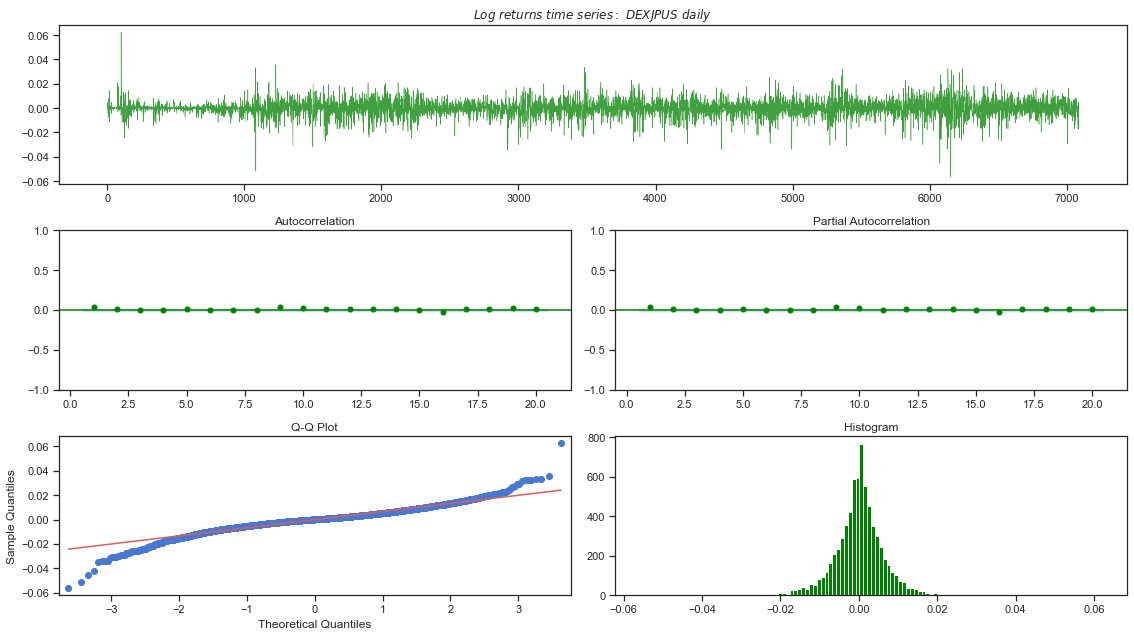

In [10]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "DEXJPUS\ daily", color='green')

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2823529411764706, 0.47058823529411764, 0.8156862745098039, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


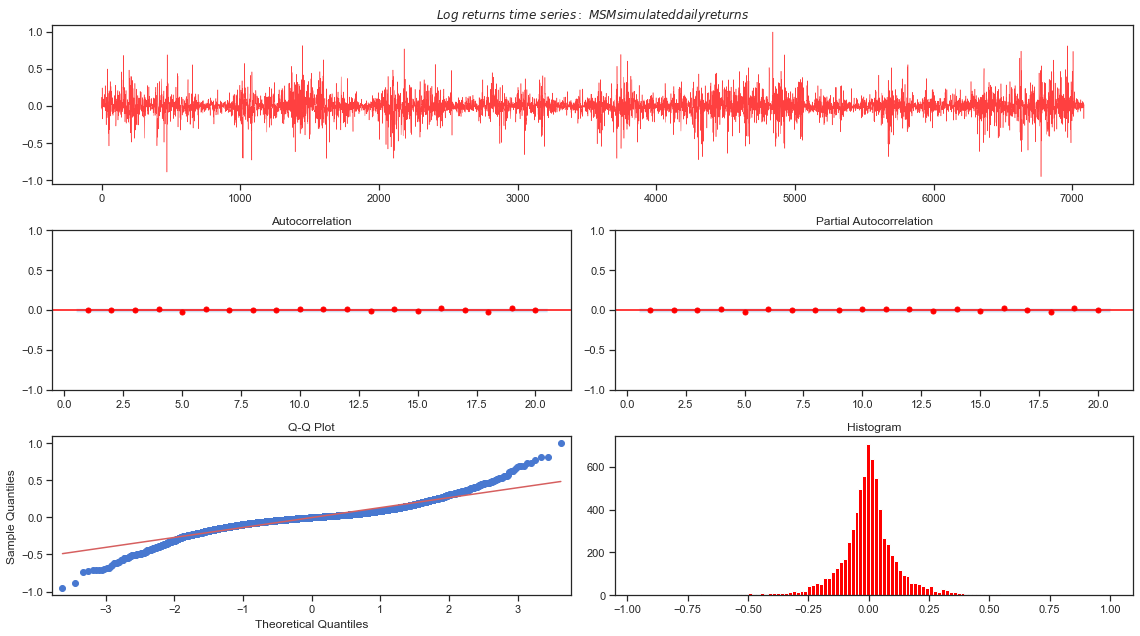

In [11]:
s = np.array(dat1).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MSM simulated daily returns", color='red')

# Model estimation

**Simulated dataset**

I apply ML estimation to the simulated dataset in order to check that my models compute parameters that are acceptably close to true. The function `simulateData_NumPy(b,m0,g_kbar,sig,kbar,T)` simulates a dataset the true parameters of which are $b = 6$, $m_0 = 1.6$, $gamma_{\bar k} = 0.8$, and ${\bar \sigma} = 2$; I further specify 5 multipliers (thus $\bar k = 5$). I set $T$ observations for the simulation, setting $T = 7087$ in order that the simulated data set is of identical length (number of observations) to the DEXJPUS dataset of the subsequent section, where I replicate the results of Calvet & Fisher (2004).  I observe that the parameters returned for the simulated data are consistently close to the true parameters over the course of a great many test runs and thus conclude that the MSM model is working correctly.

In [12]:
%%time

data = dat1E               # Simulated dta
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for Simulated dataset: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

C:\Users\hp\AppData\Local\Temp\ipykernel_30112\3478942869.py:134: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_LL" failed type inference due to: No implementation of function Function(<function dot at 0x0000013B10FDFA60>) found for signature:
 
 >>> dot(array(float64, 1d, C), none)
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 131.
    With argument(s): '(array(float64, 1d, C), none)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(array(float64, 1d, C), none)
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
     Intrinsic of function 'stub': File: numba\core\overloa

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

**DEXJPUS**

I apply ML estimation to the DEXJPUS dataset in order to replicate the results of Calvet & Fisher (2004, 2008) with the same data, thereby providing an anchor for subsequent analysis with other data.
$\\[0.1in]$

In [13]:
%%time

data = dat2E               # DEXJPUS
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)

# name parameters for later use:
b_dex = parameters[0]
m_0_dex = parameters[1]
gamma_kbar_dex = parameters[2]
sigma_dex = parameters[3]
LL_dex = LL

print("Parameters from glo_min for DEXJPUS: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_dex,"\n"
      'm_0 = %.5f' % m_0_dex,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_dex,"\n"
      'sigma = %.5f' % (sigma_dex*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_dex,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [14]:
#écriture sous format .CSV d'une base de données simulées

# Simulation de données
kbar = 4
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    
T = 2000        
dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)
print(dat1)


#écriture sous format .CSV
dates = list(range(1,T+1))
df = pd.DataFrame({'DATE': dates,
                   'LOGRETURN': dat1.flatten()})
df.to_csv('out.csv', index=False)



[[ 0.13943025]
 [-0.18074276]
 [ 0.29182676]
 ...
 [-0.04660407]
 [ 0.01009617]
 [ 0.01049993]]


***

In [15]:
#écriture sous format .CSV d'une base de données simulées

#récupération d'une base de données
dat2 = pd.read_csv("out.csv")    #on récupère les données du fichier CSV
dat2 = dat2.loc[dat2.DATAVALUE != "."].DATAVALUE.astype(float) #on ne garde que la colonne DATAVALUE (pas la colonne des dates)
dat2 = np.array(dat2) 
print("dat2")
print(dat2)



AttributeError: 'DataFrame' object has no attribute 'DATAVALUE'

In [ ]:
import yfinance as yf
# Downloading data
#SPX = yf.download('^GSPC', start = '2021-01-01', interval = '1d')
#CAC = yf.download('^FCHI', start = '2021-01-01', interval = '1d')
#VIX = yf.download('^VIX', start = SPX.index[1], interval = '1d')
import time

In [ ]:
GetFacebookInformation = yf.Ticker("FB")
 
# Let us  get historical stock prices for Facebook
# covering the past few years.
# max->maximum number of daily prices available
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y,
# 5y, 10y and ytd.

#print(GetFacebookInformation.history(period="max"))
df = GetFacebookInformation.history(period="max").to_csv('facebook.csv')
dat2 = pd.read_csv("facebook.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]

#k = stats.describe(dat2)
#print("Descriptive statistics for dat2: ","\n"
#      "Number of observations = ",k.nobs,"\n"
#      "Minimum, Maximum = ",str(k.minmax),"\n"
#      "Mean = %.5f" %  k.mean,"\n"
#      "Variance = %.5f" %  k.variance,"\n"
#      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
#      "Skewness = %.5f" %  k.skewness,"\n"
#      "Kurtosis = %.5f" %  k.kurtosis)

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "FACEBOOK", color='green')

remarque : pour différentes valeurs de b (environ 5, environ 8,etc..) on trouve la même valeur de likelihood à peu près

In [ ]:
idée : tableau avec temps de calcul en fonction de la méthode utilisée, comparer les précisions (quelle likelihood est la plus basse), augmenter kbarre, prendre des petites valeurs de T (toutes les mêmes)

In [ ]:
GetInfo = yf.Ticker("XPEV")

df = GetInfo.history(period="max").to_csv('xpeng.csv')
dat2 = pd.read_csv("xpeng.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "XPENG INC", color='green')

In [ ]:
GetInfo = yf.Ticker("F")

df = GetInfo.history(period="2y").to_csv('ford_motor_company.csv')
dat2 = pd.read_csv("ford_motor_company.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "FORD MOTOR COMPANY", color='green')

In [ ]:
print("0")
GetInfo = yf.Ticker("BAC")
print("1")
df = GetInfo.history(period="2y").to_csv('bank_of_america_corporation.csv')
dat2 = pd.read_csv("bank_of_america_corporation.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "BANK OF AMERICA CORPORATION", color='green')

In [ ]:
GetInfo = yf.Ticker("UBER")
df = GetInfo.history(period="2y").to_csv('uber.csv')
dat2 = pd.read_csv("uber.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "UBER", color='green')

In [ ]:
GetInfo = yf.Ticker("EURUSD=X")
df = GetInfo.history(period="5y").to_csv('eur_usd.csv')
dat2 = pd.read_csv("eur_usd.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "EUR/USD", color='green')

In [ ]:
GetInfo = yf.Ticker("UBSFY")
df = GetInfo.history(period="5y").to_csv('ubisoft.csv')
dat2 = pd.read_csv("ubisoft.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "UBISOFT", color='green')

In [ ]:
GetInfo = yf.Ticker("AAL")
df = GetInfo.history(period="5y").to_csv('american_airlines_group.csv')
dat2 = pd.read_csv("american_airlines_group.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "AMERICAN AIRLINES", color='green')

In [ ]:
GetInfo = yf.Ticker("TWTR")
df = GetInfo.history(period="5y").to_csv('twitter.csv')
dat2 = pd.read_csv("twitter.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "TWITTER", color='green')

In [ ]:
GetInfo = yf.Ticker("AMZN")
df = GetInfo.history(period="5y").to_csv('amazon.csv')
dat2 = pd.read_csv("amazon.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "AMAZON", color='green')

In [ ]:
GetInfo = yf.Ticker("SNAP")
df = GetInfo.history(period="5y").to_csv('snap.csv')
dat2 = pd.read_csv("snap.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "SNAP INC", color='green')

In [ ]:
GetInfo = yf.Ticker("TTE")
df = GetInfo.history(period="5y").to_csv('total_energies.csv')
dat2 = pd.read_csv("total_energies.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "TOTAL ENERGIES", color='green')

In [ ]:
GetInfo = yf.Ticker("MCD")
df = GetInfo.history(period="max").to_csv('mcdonalds.csv')
dat2 = pd.read_csv("mcdonalds.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MCDONALDS", color='green')

In [ ]:
GetInfo = yf.Ticker("ZM")
df = GetInfo.history(period="max").to_csv('zoom.csv')
dat2 = pd.read_csv("zoom.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]

kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
data=np.zeros((len(dat2),1))
data=np.array(dat2)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "ZOOM", color='green')

In [ ]:
GetInfo = yf.Ticker("SPCE")
df = GetInfo.history(period="max").to_csv('virgin_galactics.csv')
dat2 = pd.read_csv("virgin_galactics.csv")  
dat2 = dat2.loc[dat2.Open != "."].Open.astype(float)
dat2 = np.array(dat2) 
dat2 = dat2[dat2 != 0]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return

dat2 = dat2[:,np.newaxis]
#print(dat2)
kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0
#data=np.zeros((len(dat2),1))
#data=np.array(dat2)
#print(data)
print('go')
start = time.perf_counter()
parameters, LL, niter, output = glo_min(kbar, dat2, niter, temperature, stepsize)
end = time.perf_counter()

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for dat2: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      #"niter = " , niter,"\n"
      #"output = " , output,"\n"
      'Temps de calcul :', end-start, "\n"
     )

s = np.array(data).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "VIRGIN GALACTICS", color='green')

In [ ]:
# parameters used for MSM
kbar=4
niter = 1
temperature = 1.0
stepsize = 1.0

# Symbols used
Symbols = ["FB","F","SNAP","TWTR", "XPEV", "UBER", "TTE", "EURUSD=X", "UBSFY", "MCD", "AMZN", "SPCE", "ZM", "AAL", "BAC"]

for symbol in Symbols:
    
    # data shaping
    GetInfo = yf.Ticker(symbol)
    df = GetInfo.history(period="2y").to_csv(symbol + ".csv")
    data = pd.read_csv(symbol + ".csv")  
    data = data.loc[data.Open != "."].Open.astype(float)
    data = np.array(data) 
    data = data[data != 0]
    data = np.log(data[1:])-np.log(data[0:-1])
    data = data[:,np.newaxis]
    
    # running MSM
    start = time.perf_counter()
    parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)
    end = time.perf_counter()

    # name parameters for later use:
    b_sim = parameters[0]
    m_0_sim = parameters[1]
    gamma_kbar_sim = parameters[2]
    sigma_sim = parameters[3]
    LL_sim = LL

    print("Parameters from glo_min for " + symbol + " data: ", "\n"
          "kbar = ", kbar,"\n"
          'b = %.5f' % b_sim,"\n"
          'm_0 = %.5f' % m_0_sim,"\n"
          'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
          'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
          'Likelihood = %.5f' % LL_sim,"\n"
          #"niter = " , niter,"\n"
          #"output = " , output,"\n"
          'Calculation time :', end-start, "\n"
         )

    s = np.array(data).astype(float)
    s = s[s != 0].copy()
    tsdisplay(s, title = symbol, color='green')